# Accelerometer Filter Testing

This notebook tests filters on Android accelerometer data. Using the Physics Toolbox Accelerometer app I obtained test data where I knew what forces the phone underwent. Some details:
* The accelerometer data is in g-forces. For visualization I have multipled the data by 9.81 m/s^2 so we have it on a better visual scale.
* The phone was placed flat on a table. I hit the table a few times with my fist and also bumped it a few times. This is the noise we want to eliminate from the data. 
* We test a Kalman Filter and a low-pass butterworth filter for this data
* However SAE recommends a fairly harsh low-pass filter with a cut-off of 300 Hz. That is for vehicle accelerations which tend to contain high-frequency ( > 1650 Hz ) noise.

In [16]:
# Imports
import numpy as np
import pandas as pd
import csv
import re 
import pylab as pl
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, lfilter
%matplotlib inline

In [9]:
# My data

# Read the CSV file in (skipping first row).
csvRows = []
csvFileObj = open('flatontable.csv')
readerObj = csv.reader(csvFileObj)
for row in readerObj:
    if readerObj.line_num == 1:
        continue    # skip first row
    csvRows.append(row)
csvFileObj.close()

# Make arrays for processing

time = []
Gx = []
Gy = []
Gz = []
gtotal = []

# Acceleration values are in 'g' units. I am multiplying out by 9.81 to scale it up
g = -9.81
for i in xrange(len(csvRows)):
    time.append(float(csvRows[i][0]))
    Gx.append(g*float(csvRows[i][1]))
    Gy.append(g*float(csvRows[i][2]))
    Gz.append(g*float(csvRows[i][3]))
    gtotal.append(float(csvRows[i][4]))

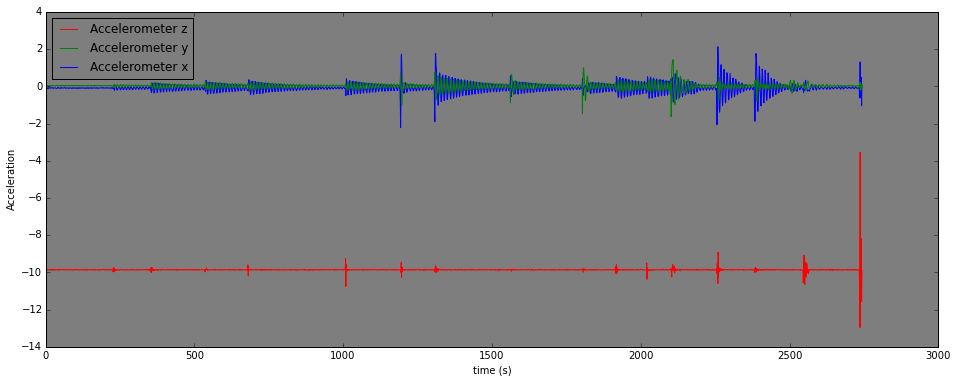

In [10]:
fig = plt.figure(figsize=(16, 6))

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.9)

ax = fig.add_subplot(111)

x = ax.plot(Gx,label="Accelerometer x")
ay = ax.plot(Gy,label="Accelerometer y")
az = ax.plot(Gz,label="Accelerometer z")

handles, labels = ax.get_legend_handles_labels()

ax.patch.set_facecolor('black')
ax.patch.set_alpha(0.5)
# reverse the order
ax.legend(handles[::-1], labels[::-1],loc='best')
#plt.ylim((-10,10))
plt.xlabel('time (s)')
plt.ylabel('Acceleration')
# If we don't specify the edgecolor and facecolor for the figure when
# saving with savefig, it will override the value we set earlier!
fig.savefig('Acceleromter_phone_raw.png', facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()

# Apply Kalman Filter

In [14]:
from pykalman import KalmanFilter
n_timesteps = len(Gx)
x = np.linspace(0, n_timesteps, n_timesteps)
# observations[0] is Gx, etc.
observations = [Gx,Gy,Gz]

# create a Kalman Filter by hinting at the size of the state and observation
# space.  If you already have good guesses for the initial parameters, put them
# in here.  The Kalman Filter will try to learn the values of all variables.
kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  transition_covariance=0.01 * np.eye(2))

# You can use the Kalman Filter immediately without fitting, but its estimates
# may not be as good as if you fit first.
states_predx = kf.em(observations[0]).smooth(observations[0])[0]
states_predy = kf.em(observations[1]).smooth(observations[1])[0]
states_predz = kf.em(observations[2]).smooth(observations[2])[0]

2744 2744


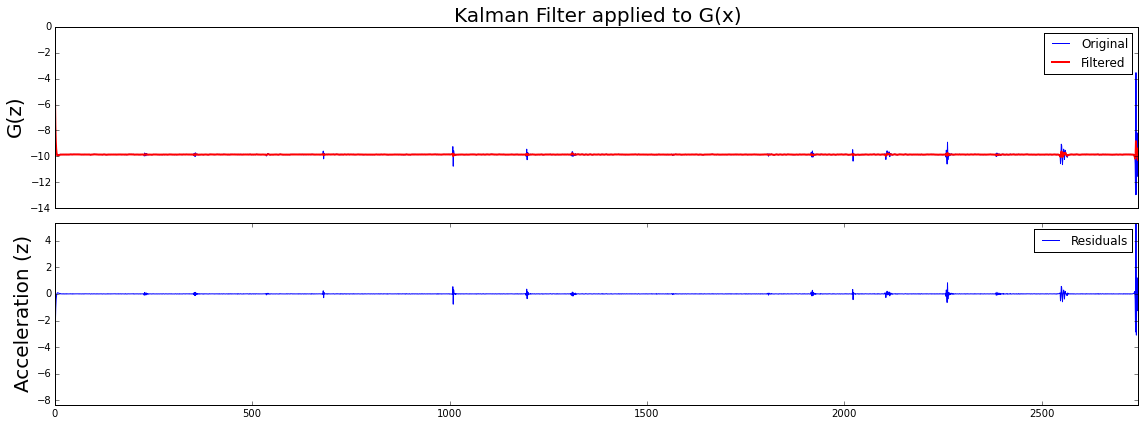

In [56]:

# Make plots
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(211)
plt.plot(x,observations[2], 'b-')
plt.plot(x,states_predz[:, 0], 'r-',linewidth=2)
plt.xlim(0,max(x))
plt.ylabel("G(z)",fontsize=20)
plt.xlabel("time (s)",fontsize=20)
plt.legend(['Original','Filtered'],loc='best')
plt.title("Kalman Filter applied to G(x)",fontsize=20)
plt.tight_layout()
ax1.axes.get_xaxis().set_visible(False)

# Difference
ax1 = fig.add_subplot(212)
plt.plot(x,observations[2] - states_predz[:, 0] , 'b-')
plt.xlim(0,max(x))
plt.ylim(min(observations[2] - states_predz[:, 0]),max(observations[2] - states_predz[:, 0]))
plt.ylabel("Acceleration (z)",fontsize=20)
plt.xlabel("time (s)",fontsize=20)
plt.legend(['Residuals'],loc='best')
plt.tight_layout()



# Apply Butterworth Filter

In [41]:
N  = 9    # Filter order
Wn = 0.1 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
tempf = signal.filtfilt(B,A,Gz)

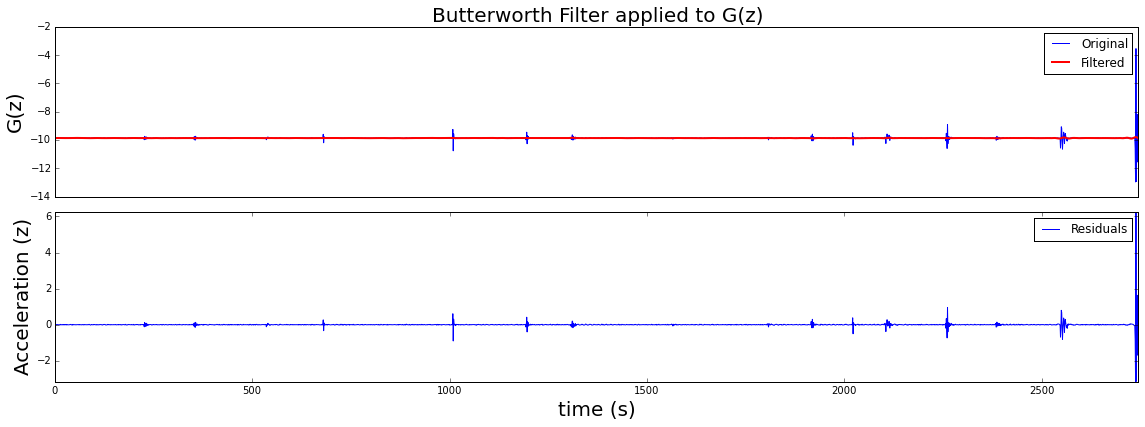

In [57]:
# Make plots
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(211)
plt.plot(x,observations[2], 'b-')
plt.plot(x,tempf, 'r-',linewidth=2)
plt.xlim(0,max(x))
plt.ylabel("G(z)",fontsize=20)
plt.xlabel("time (s)",fontsize=20)
plt.legend(['Original','Filtered'],loc='best')
plt.title("Butterworth Filter applied to G(z)",fontsize=20)
plt.tight_layout()
ax1.axes.get_xaxis().set_visible(False)

# Difference
ax1 = fig.add_subplot(212)
plt.plot(x,observations[2] - tempf , 'b-')
plt.xlim(0,max(x))
plt.ylim(min(observations[2] - tempf),max(observations[2] - tempf))
plt.ylabel("Acceleration (z)",fontsize=20)
plt.xlabel("time (s)",fontsize=20)
plt.legend(['Residuals'],loc='best')
plt.tight_layout()


# Moving Average Filter

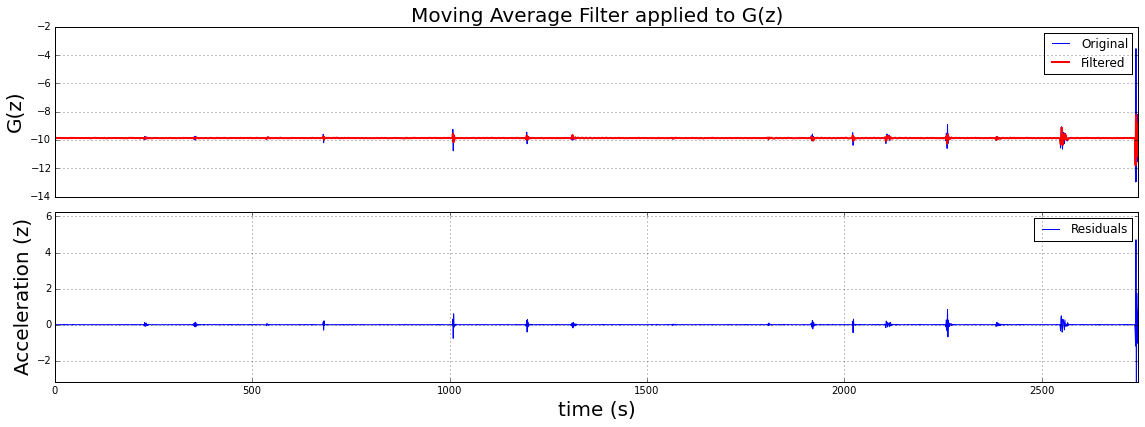

In [58]:
# This solution is from here
# http://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python
from __future__ import division
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy import linspace, loadtxt, ones, convolve
import numpy as numpy

def movingaverage(interval, window_size):
    window= numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

x = x
y = Gz

y_av = movingaverage(y, 2)

# Plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(211)
plt.plot(x,y, 'b-')
plt.plot(x,y_av, 'r-',linewidth=2)
plt.xlim(0,max(x))
plt.ylabel("G(z)",fontsize=20)
plt.xlabel("time (s)",fontsize=20)
plt.legend(['Original','Filtered'],loc='best')
plt.title("Moving Average Filter applied to G(z)",fontsize=20)
plt.tight_layout()
grid(True)
ax1.axes.get_xaxis().set_visible(False)

# Difference
ax1 = fig.add_subplot(212)
plt.plot(x,y - y_av , 'b-')
plt.xlim(0,max(x))
plt.ylim(min(observations[2] - tempf),max(observations[2] - tempf))
plt.ylabel("Acceleration (z)",fontsize=20)
plt.xlabel("time (s)",fontsize=20)
plt.legend(['Residuals'],loc='best')
plt.tight_layout()
grid(True)
